<a href="https://colab.research.google.com/github/hongyuw0427/Final-Year-Project/blob/main/FYP_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Fixed & memory-friendly hyperparameter tuning script
# - Uses sparse TF-IDF (no .toarray())
# - Uses LinearSVC + CalibratedClassifierCV for speed & probabilities
# - Combines sparse TF-IDF + dense embeddings via scipy.sparse.hstack
# - Smaller search spaces, cv=2, n_jobs=1 to limit memory
# - BiLSTM tuning uses small search and smaller model sizes

import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# faster SVM for sparse data
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q -U keras-tuner
import tensorflow as tf
import keras_tuner as kt

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# ----------------------------
# Config
# ----------------------------
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_cleaned_dropOverlappedRows.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning_2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(DATA_PATH)
texts = df["clean_text"].astype(str).tolist()
labels = df["cyberbullying_type"].astype(str).tolist()

le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# fixed split for tuning (80/20)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.1, random_state=SEED, stratify=y
)

# ----------------------------
# Confusion matrix helper
# ----------------------------
def show_and_save_confusion_matrix(y_true, y_pred, labels, filename):
    cm = confusion_matrix(y_true, y_pred)
    print("\n" + "="*40)
    print(f"Confusion Matrix: {filename}")
    print("="*40)
    print(cm)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(filename)
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path)
    plt.show()
    print("Saved:", save_path)

# ----------------------------
# Feature extraction for classical models (fusion)
# Keep TF-IDF sparse (no .toarray())
# ----------------------------
print("Computing TF-IDF (sparse)...")
tfidf = TfidfVectorizer(max_features=3000,  # reduce features to save memory
                        ngram_range=(1,2),
                        stop_words='english')
tfidf.fit(texts)
X_train_tfidf = tfidf.transform(X_train_text)   # sparse
X_test_tfidf  = tfidf.transform(X_test_text)    # sparse

print("Computing sentence embeddings (dense)...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
# encode in batches is handled by sentence-transformers
X_train_emb = embedder.encode(X_train_text, convert_to_numpy=True, show_progress_bar=True)
X_test_emb  = embedder.encode(X_test_text, convert_to_numpy=True, show_progress_bar=True)

# convert dense embeddings to sparse CSR to hstack with tfidf, but we can hstack with dense as well using scipy
X_train_emb_sp = csr_matrix(X_train_emb)
X_test_emb_sp  = csr_matrix(X_test_emb)

print("Combining TF-IDF (sparse) + Embeddings (sparse) via hstack...")
X_train = hstack([X_train_tfidf, X_train_emb_sp], format='csr')
X_test  = hstack([X_test_tfidf,  X_test_emb_sp],  format='csr')

print("Fusion shapes:", X_train.shape, X_test.shape)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.1 MB/s eta 0:00:00
Classes: ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']
Computing TF-IDF (sparse)...
Computing sentence embeddings (dense)...


Batches:   0%|          | 0/1082 [00:00<?, ?it/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

Combining TF-IDF (sparse) + Embeddings (sparse) via hstack...
Fusion shapes: (34605, 3384) (3845, 3384)



TUNING SVM (LinearSVC wrapped with CalibratedClassifierCV)...
Training LinearSVC (C=0.1) + calibration...
 C=0.1 -> f1_macro=0.9222
Training LinearSVC (C=1) + calibration...
 C=1 -> f1_macro=0.9244
Training LinearSVC (C=3) + calibration...
 C=3 -> f1_macro=0.9228
Best SVM params: {'C': 1} best f1: 0.9244015671512598

Confusion Matrix: CM_SVM_TUNED.png
[[770   4   4  15   2]
 [  0 772   1  10   2]
 [  2   0 639 106   7]
 [ 15   8  40 642  31]
 [  0   1   3  36 735]]


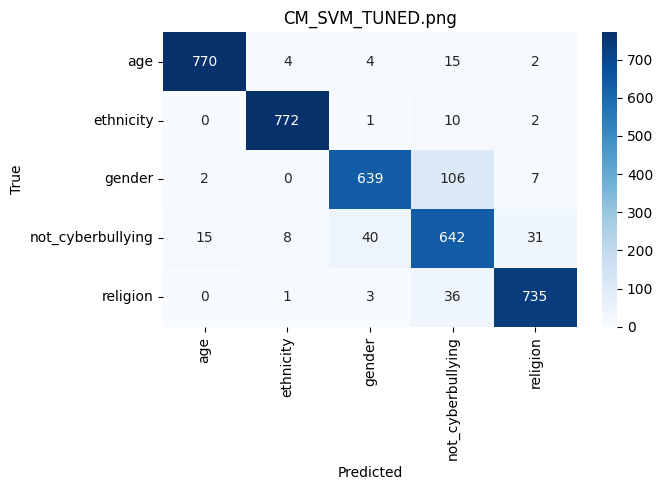

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning_2/CM_SVM_TUNED.png


In [6]:
# ----------------------------
# TUNE SVM (use LinearSVC + CalibratedClassifierCV)
# - smaller grid, cv=2, n_jobs=1 to avoid memory spikes
# ----------------------------
print("\nTUNING SVM (LinearSVC wrapped with CalibratedClassifierCV)...")

svc = LinearSVC(random_state=SEED, max_iter=10000)
calib = CalibratedClassifierCV(svc, cv=2)   # cv=2 inside calibration

param_grid_svc = {
    "base_estimator__C": [0.1, 1, 3]  # small grid
}


best_svm = None
best_score = -1
best_params = None

for C in [0.1, 1, 3]:
    print(f"Training LinearSVC (C={C}) + calibration...")
    svc = LinearSVC(C=C, random_state=SEED, max_iter=10000)
    calib = CalibratedClassifierCV(svc, cv=2)
    calib.fit(X_train, y_train)   # supports sparse input
    preds = calib.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')
    print(f" C={C} -> f1_macro={f1:.4f}")
    if f1 > best_score:
        best_score = f1
        best_svm = calib
        best_params = {"C": C}

print("Best SVM params:", best_params, "best f1:", best_score)

svm_pred = best_svm.predict(X_test)
svm_proba = best_svm.predict_proba(X_test)

show_and_save_confusion_matrix(y_test, svm_pred, le.classes_, "CM_SVM_TUNED.png")

svm_results = {
    "model": "SVM_TUNED",
    "accuracy": accuracy_score(y_test, svm_pred),
    "precision": precision_score(y_test, svm_pred, average="macro"),
    "recall": recall_score(y_test, svm_pred, average="macro"),
    "f1": f1_score(y_test, svm_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             svm_proba, average="macro", multi_class="ovr")
}




TUNING Logistic Regression (fusion)...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best LR params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'} best f1: 0.9224744029994887

Confusion Matrix: CM_LR_TUNED.png
[[771   3   4  15   2]
 [  0 766   2  14   3]
 [  2   3 634 108   7]
 [ 19   9  45 636  27]
 [  0   1   2  34 738]]


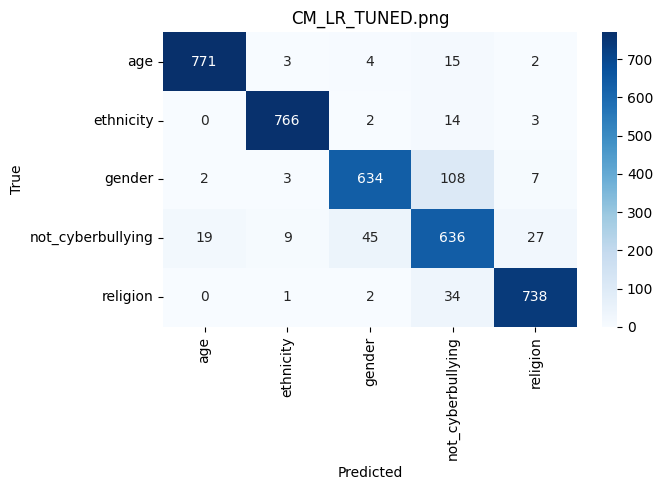

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning_2/CM_LR_TUNED.png


In [8]:
# ----------------------------
# TUNE Logistic Regression (fusion)
# - small grid; solver lbfgs supports l2 only; saga is fine but slower
# - use n_jobs=1 to reduce parallel memory spikes
# ----------------------------
print("\nTUNING Logistic Regression (fusion)...")
param_grid_lr = {
    "C": [0.1, 1, 3],
    "solver": ["lbfgs"],   # keep simple and stable
    "penalty": ["l2"]
}

lr = LogisticRegression(max_iter=2000)
grid_lr = GridSearchCV(lr, param_grid_lr, scoring="f1_macro", cv=2, verbose=1, n_jobs=1)
grid_lr.fit(X_train, y_train)   # accepts sparse matrices

best_lr = grid_lr.best_estimator_
print("Best LR params:", grid_lr.best_params_, "best f1:", grid_lr.best_score_)

lr_pred = best_lr.predict(X_test)
lr_proba = best_lr.predict_proba(X_test)

show_and_save_confusion_matrix(y_test, lr_pred, le.classes_, "CM_LR_TUNED.png")

lr_results = {
    "model": "LR_TUNED",
    "accuracy": accuracy_score(y_test, lr_pred),
    "precision": precision_score(y_test, lr_pred, average="macro"),
    "recall": recall_score(y_test, lr_pred, average="macro"),
    "f1": f1_score(y_test, lr_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             lr_proba, average="macro", multi_class="ovr")
}



Trial 4 Complete [00h 05m 59s]
val_accuracy: 0.9338341355323792

Best val_accuracy So Far: 0.9338341355323792
Total elapsed time: 00h 23m 36s
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step

Confusion Matrix: CM_BiLSTM_TUNED.png
[[772   2   3  17   1]
 [  3 767   4   9   2]
 [  2   5 642  98   7]
 [  5   7  18 686  20]
 [  2   1   3  42 727]]


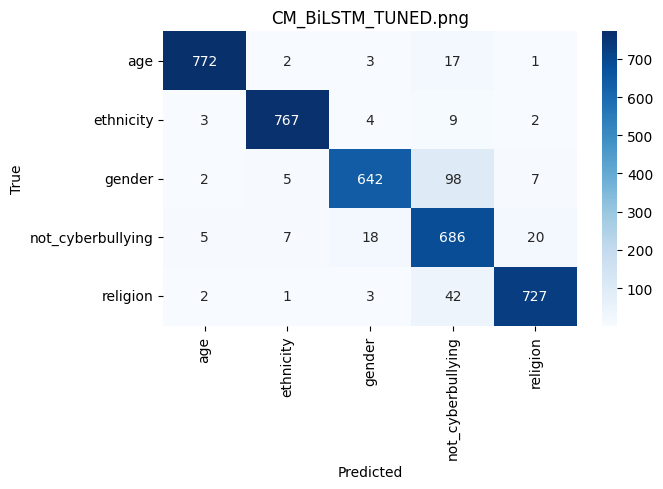

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning_2/CM_BiLSTM_TUNED.png


In [9]:
import tensorflow as tf
import keras_tuner as kt

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----------------------------
# TUNE BiLSTM (deep learning) — separate representation (TOKENIZED sequences)
# - use smaller vocab and shorter search to avoid RAM crash
# ----------------------------
print("\nTUNING BiLSTM (tokenized sequences)...")

MAX_WORDS = 20000
MAX_LEN = 100

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)


def build_bilstm(hp):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=hp.Int("embed_dim", 32, 64, step=32)
    ))

    model.add(layers.Bidirectional(layers.LSTM(
        hp.Int("lstm_units", 32, 64, step=16)
    )))

    model.add(layers.Dense(
        hp.Int("dense_units", 32, 64, step=16),
        activation="relu"
    ))

    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_bilstm,
    objective="val_accuracy",
    max_trials=4,
    executions_per_trial=1,
    directory=OUTPUT_DIR,
    project_name="bilstm_tuning_small"
)

tuner.search(X_train_pad, y_train, epochs=3, validation_split=0.1, verbose=2)

best_bilstm = tuner.get_best_models(num_models=1)[0]
bilstm_pred_proba = best_bilstm.predict(X_test_pad, batch_size=128)
bilstm_pred = np.argmax(bilstm_pred_proba, axis=1)

show_and_save_confusion_matrix(y_test, bilstm_pred, le.classes_, "CM_BiLSTM_TUNED.png")

bilstm_results = {
    "model": "BiLSTM_TUNED",
    "accuracy": accuracy_score(y_test, bilstm_pred),
    "precision": precision_score(y_test, bilstm_pred, average="macro"),
    "recall": recall_score(y_test, bilstm_pred, average="macro"),
    "f1": f1_score(y_test, bilstm_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             bilstm_pred_proba, average="macro", multi_class="ovr")
}



In [10]:
# ----------------------------
# Save results
# ----------------------------
results_df = pd.DataFrame([svm_results, lr_results, bilstm_results])
out_path = os.path.join(OUTPUT_DIR, "tuning_results.csv")
results_df.to_csv(out_path, index=False)
print("\nTUNING COMPLETE — results saved to:", out_path)
print(results_df)


TUNING COMPLETE — results saved to: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning_2/tuning_results.csv
          model  accuracy  precision    recall        f1   roc_auc
0     SVM_TUNED  0.925358   0.926298  0.924029  0.924402  0.989594
1      LR_TUNED  0.921977   0.922758  0.920569  0.920930  0.990180
2  BiLSTM_TUNED  0.934720   0.937851  0.933946  0.934305  0.992502


# Co-Relationship analysis

In [3]:
# ============================================
# FULL CORRELATION ANALYSIS:
# other_cyberbullying vs not_cyberbullying
# ============================================




import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer, util

# --------------------------------------------------
# 1. Load dataset
# --------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv")

# Filter only the two classes
df_sub = df[df["cyberbullying_type"].isin(["other_cyberbullying", "not_cyberbullying"])].copy()
df_sub.reset_index(drop=True, inplace=True)

texts = df_sub["clean_text"].astype(str).tolist()
labels = df_sub["cyberbullying_type"].tolist()

print("Dataset shape:", df_sub.shape)
print(df_sub["cyberbullying_type"].value_counts(), "\n")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
label_names = le.classes_

# --------------------------------------------------
# 2. Train/test split and baseline classifier for confusion matrix
# --------------------------------------------------
from sklearn.linear_model import LogisticRegression

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix (other vs not):")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=label_names, columns=label_names), "\n")

# --------------------------------------------------
# 3. TF-IDF Cosine Similarity (semantic closeness)
# --------------------------------------------------
print("Computing TF-IDF similarity...")

other_texts = df[df["cyberbullying_type"]=="other_cyberbullying"]["clean_text"].astype(str).tolist()
not_texts = df[df["cyberbullying_type"]=="not_cyberbullying"]["clean_text"].astype(str).tolist()

tfidf_all = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_all.fit_transform(other_texts + not_texts)

o = tfidf_matrix[:len(other_texts)]
n = tfidf_matrix[len(other_texts):]

# FIX: convert sparse mean to numpy array
o_mean = np.asarray(o.mean(axis=0))
n_mean = np.asarray(n.mean(axis=0))

tfidf_sim = cosine_similarity(o_mean, n_mean)[0][0]
print("TF-IDF Average Similarity:", round(tfidf_sim, 4), "\n")


# --------------------------------------------------
# 4. Sentence Embedding Similarity (MiniLM)
# --------------------------------------------------
print("Computing BERT-like embedding similarity...")

embedder = SentenceTransformer("all-MiniLM-L6-v2")

embed_other = embedder.encode(other_texts, convert_to_numpy=True, show_progress_bar=True)
embed_not   = embedder.encode(not_texts, convert_to_numpy=True, show_progress_bar=True)

emb_sim = util.cos_sim(embed_other.mean(axis=0), embed_not.mean(axis=0)).item()
print("Embedding Semantic Similarity:", round(emb_sim, 4), "\n")

# --------------------------------------------------
# 5. Show misclassified examples between the two classes
# --------------------------------------------------
mis = pd.DataFrame({
    "text": X_test_text,
    "true": le.inverse_transform(y_test),
    "pred": le.inverse_transform(y_pred)
})

mis_filtered = mis[
    (
        (mis["true"]=="other_cyberbullying") &
        (mis["pred"]=="not_cyberbullying")
    )
    |
    (
        (mis["true"]=="not_cyberbullying") &
        (mis["pred"]=="other_cyberbullying")
    )
]

print("Examples of confusion between the two classes:\n")
print(mis_filtered.head(20).to_string(index=False), "\n")

# --------------------------------------------------
# 6. Interpretation based on similarity
# --------------------------------------------------

print("===== INTERPRETATION =====")
if emb_sim > 0.7:
    print("➡ High semantic similarity (>0.70). These two classes are naturally overlapping.")
elif emb_sim > 0.5:
    print("➡ Moderate similarity (0.50–0.70). Model confusion is expected.")
else:
    print("➡ Low similarity (<0.50). Confusion likely due to model/feature limitations.")

print("\nRecommended Fixes:")
print("- Add sentiment polarity features (negative vs neutral)")
print("- Add toxicity / hate speech scores (like Perspective API)")
print("- Train a separate classifier only for these 2 classes")
print("- Consider merging if dataset definitions overlap too much")


Dataset shape: (14643, 5)
cyberbullying_type
not_cyberbullying      7357
other_cyberbullying    7286
Name: count, dtype: int64 

Confusion Matrix (other vs not):
                     not_cyberbullying  other_cyberbullying
not_cyberbullying                  955                  517
other_cyberbullying                461                  996 

Computing TF-IDF similarity...
TF-IDF Average Similarity: 0.8463 

Computing BERT-like embedding similarity...


Batches:   0%|          | 0/228 [00:00<?, ?it/s]

Batches:   0%|          | 0/230 [00:00<?, ?it/s]

Embedding Semantic Similarity: 0.9676 

Examples of confusion between the two classes:

                                                                                       text                true                pred
                    try amp claim innocence statistic paint someone avoid ive sight oh well   not_cyberbullying other_cyberbullying
                    thanks goodness internet allows people bully anonymously right confront   not_cyberbullying other_cyberbullying
                     ok whenever youve calmed poke facebook ill tell problem wthe code base   not_cyberbullying other_cyberbullying
                                                                                  mrrglgrgl other_cyberbullying   not_cyberbullying
                                                                         cant shelter serve other_cyberbullying   not_cyberbullying
                                                       dont answer sanctimonious complainer   not_cyberbullying other_cy

In [4]:
# Drop rows where class is 'other_cyberbullying'
df_no_other = df[df["cyberbullying_type"] != "other_cyberbullying"].copy()

print("Original shape:", df.shape)
print("After dropping other_cyberbullying:", df_no_other.shape)

# Check new class distribution
print(df_no_other["cyberbullying_type"].value_counts())

SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_cleaned_dropOverlappedRows.csv"
df_no_other.to_csv(SAVE_PATH, index=False)

print("Saved cleaned dataset to:", SAVE_PATH)


Original shape: (45736, 5)
After dropping other_cyberbullying: (38450, 5)
cyberbullying_type
age                  7955
ethnicity            7846
religion             7754
gender               7538
not_cyberbullying    7357
Name: count, dtype: int64
Saved cleaned dataset to: /content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_cleaned_dropOverlappedRows.csv
